# CalTech 101 - Object classification

In this experiment, we're going to do object classification using Caltech 101 dataset. The dataset is available [here](http://www.vision.caltech.edu/Image_Datasets/Caltech101/Caltech101.html#Discussion). The dataset contains images of 101 different objects, but isn't a large dataset. In fact, average number of images per category is just about 50. 

In this notebook, we do the following:
1. **Imports** -- For each import, I've given the reason so it doesn't feel like a bunch of imports just put together.

2. **[Download the dataset from the URL and extract it](#Download-the-dataset-to-a-folder-inside-this-directory)**

3. **[Exploring dataset](#Exploring-dataset)** -- Here, we write basic methods to read images programmatically and check their shapes. Further, we see [how many images do we have per category](#How-many-images-we-have-for-each-category?)

4. **[Create Dataset for ML](#Creating-Dataset-for-some-ML)** -- When you wish to use any frameworks/tools and do some machine learning, you need to have your training data, and testing data in a standard format. We will be creating our X and Y here. For object categories, we turn them to [one-hot encoded labels](#Making-one-hot-encoded-labels), and X is a [normalized numpy image array](#Basic-Normalization-(in-case-of-images)).
Finally, we split the data to training and validation data. We choose 75% for training and 25% for validation purposes.

5. **We try three different convolutional network approaches**, out of which two are written from scratch to test how they perform, while one is based on transfer learning and uses InceptionV3 as base model. We use Keras for this. An idea is brought from [SimpNet](https://arxiv.org/abs/1802.06205) paper, which is to not overly complicate the architecture or use larger kernel sizes without trying for smaller kernel sizes. Another thing that's common between both architectures is the use of softmax activation for the last layer - This makes sense since it is a multi-classification problem. For the same reason, categorical_crossentropy has been used as the loss function in both cases.

    1. **[The first CNN Model](#Approach-1---A-Small-CNN)** - is a simple CNN which involves a couple of groups of Convolutional and MaxPooling layers followed by a single Fully Connected layer of 101 hidden units, standing for the 101 different classes. Validation accuracy of about 60% is peaked and high overfitting is observed.
    
    2. **[The second CNN Model](#Approach-2---CNN-Model-with-Dropout)** - uses Dropout layers and a bit deeper architecture. Almost similar validation accuracy is observed. While training, we can observe that overfitting isn't as great as in the first case.
    
    3. **[InceptionV3 based Transfer Learning](#Approach-3---Transfer-Learning)** - This model uses inceptionV3 as base model and just trains the last inception block and few Fully Connected layers added at the end. This performs the best among all models, however, could be thought of as overkill as it is quite a deep architecture for a small and easy dataset like Caltech.
    
    
6. **[The average accuracy per category](#Accuracy-per-category)** - On the [discussion page](http://www.vision.caltech.edu/Image_Datasets/Caltech101/Caltech101.html#Discussion) of dataset, they suggest that to compare your results to existing papers, you should either use a specific number of training and testing examples OR, find accuracy per category and then average it out. In this section, we've tried finding average accuracy per category and it comes out to be about 83% for the models we've written from scratch - which is not bad. For the transfer learning model, it goes beyond 97%! 

7. **[What else can we do?](#What-else-can-we-do?)** - This section states what more could be done with this dataset if we had more time. 

## All Imports and their reasons

In [4]:
import urllib.request
import os

# For extracting dataset
import tarfile

# For reading images
import cv2

# Essentials :)
import numpy as np
# pretty printing python objects
import pprint

# for sorting dictionary by value
import operator
# for showing images inline
from matplotlib.pyplot import imshow 
%matplotlib inline 

# for making labels one-hot encoded
from sklearn.preprocessing import LabelEncoder
import keras.utils

# for splitting data into training and validation data
from sklearn.model_selection import train_test_split

# for CNN and NN models

from keras.models import Sequential, Model
from keras.layers import Conv2D, Input, Dropout, Activation, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model

# For transfer learning
from keras.applications.inception_v3 import InceptionV3

# to save models
import json

# for saving environment of notebook
import dill

# for printing size each variable is using
import sys
print("import done.")

import done.


## Download the dataset to a folder inside this directory

This will download the dataset if it has not been downloaded. Further, we extract the dataset as well into /data/ directory in the current working directory. 

In [6]:
URL_CALTECH_101_DATA = 'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'
#using the drive id of the file to download from google drive
file_id = '137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp'
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id,
                                    dest_path='./dataset.tar.gz')
print("download done")


download done


In [5]:
def extract_dataset(dataset_file_path, extraction_directory):
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)
    if (dataset_file_path.endswith("tar.gz") or dataset_file_path.endswith(".tgz")):
        tar = tarfile.open(dataset_file_path, "r:gz")
        tar.extractall(path=extraction_directory)
        tar.close()
    elif (dataset_file_path.endswith("tar")):
        tar = tarfile.open(dataset_file_path, "r:")
        tar.extractall(path=extraction_directory)
        tar.close()
    print("extraction done")

extract_dataset('./dataset.tar.gz','./data/')


extraction done


## Exploring dataset

In [6]:
def get_images(object_category, data_directory):
    if (not os.path.exists(data_directory)):
        print("Data directory not found. Are you sure you downloaded and extracted dataset properly?")
        return
    obj_category_dir = os.path.join(os.path.join(data_directory,"101_ObjectCategories"),object_category)
    images = [os.path.join(obj_category_dir,img) for img in os.listdir(obj_category_dir)]
    return images

def read_image(image_path):
    """Read and resize individual images - Caltech 101 avg size of image is 300x200, so we resize accordingly"""
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (300,200), interpolation=cv2.INTER_CUBIC)
    return img

In [7]:
dolphin_imgs = get_images('dolphin','./data')

In [8]:
dolphin_imgs[0]

'./data/101_ObjectCategories/dolphin/image_0032.jpg'

In [9]:
dolphin_test_img = read_image(dolphin_imgs[0])

In [10]:
dolphin_test_img.shape

(200, 300, 3)

#### How many images we have for each category?

In [11]:
def return_images_per_category(data_directory):
    categories = os.listdir(data_directory+"/101_ObjectCategories/")
    object_images_count_dict = {}
    for category in categories:
        object_images_count_dict[category] = len(os.listdir(data_directory+"/101_ObjectCategories/"+category))
    object_images_count_dict = sorted(object_images_count_dict.items(), key=operator.itemgetter(1), reverse=True)
    return object_images_count_dict

In [12]:
return_images_per_category('./data')

[('airplanes', 800),
 ('Motorbikes', 798),
 ('BACKGROUND_Google', 468),
 ('Faces', 435),
 ('Faces_easy', 435),
 ('watch', 239),
 ('Leopards', 200),
 ('bonsai', 128),
 ('car_side', 123),
 ('ketch', 114),
 ('chandelier', 107),
 ('hawksbill', 100),
 ('grand_piano', 99),
 ('brain', 98),
 ('butterfly', 91),
 ('helicopter', 88),
 ('menorah', 87),
 ('starfish', 86),
 ('kangaroo', 86),
 ('trilobite', 86),
 ('sunflower', 85),
 ('buddha', 85),
 ('ewer', 85),
 ('scorpion', 84),
 ('revolver', 82),
 ('laptop', 81),
 ('ibis', 80),
 ('llama', 78),
 ('minaret', 76),
 ('umbrella', 75),
 ('electric_guitar', 75),
 ('crab', 73),
 ('crayfish', 70),
 ('cougar_face', 69),
 ('dragonfly', 68),
 ('flamingo', 67),
 ('dalmatian', 67),
 ('ferry', 67),
 ('lotus', 66),
 ('dolphin', 65),
 ('joshua_tree', 64),
 ('stop_sign', 64),
 ('soccer_ball', 64),
 ('euphonium', 64),
 ('elephant', 64),
 ('schooner', 63),
 ('chair', 62),
 ('lamp', 61),
 ('yin_yang', 60),
 ('wheelchair', 59),
 ('rhino', 59),
 ('stegosaurus', 59),
 (

In [13]:
len(return_images_per_category('./data'))

102

**The number of objects we need to classify is 101. So, we can actually ignore the BACKGROUND_Google directory**

## Creating Dataset for some ML

For machine learning, we need to convert the dataset into X and Y, wherein 

*X* would look something like **(num_of_total_images, ROWS, COLS, CHANNELS)** 

`The ROWS and COLS need to be fixed, however we have varied sized images. This is why the read_image method above resizes each image to 300x200 which is the average size of images (so most images wouldn't be affected).`

*Y* would be **(num_of_total_images, 1)**

**What's the total number of images we need in our dataset?**

In [14]:
total_count = 0
for category,count in return_images_per_category('./data'):
    if category == 'BACKGROUND_Google':
        continue;
    total_count += count
print("Total number of images in training data : ",total_count)

Total number of images in training data :  8677


In [15]:
def create_training_data(data_directory):
    i = 0
    X = np.ndarray((8677, 200, 300, 3), dtype=np.uint8)
    Y = []
    print("Preparing X and Y for dataset...")
    for category,_ in return_images_per_category(data_directory):
        if category == 'BACKGROUND_Google':
            continue
        print("Processing images of ",category)
        for image in get_images(category, data_directory):
            if not image.endswith('.jpg'):
                # to escape hidden ipynb checkpoints and other unnecessary files 
                continue
            X[i] = read_image(image)
            Y.insert(i,category) 
            i += 1
        print("Images processed : ",i+1," of 8678")
    print("Datasets constructed")
    return X,Y

In [16]:
X, Y = create_training_data('./data')

Preparing X and Y for dataset...
Processing images of  airplanes
Images processed :  801  of 8678
Processing images of  Motorbikes
Images processed :  1599  of 8678
Processing images of  Faces
Images processed :  2034  of 8678
Processing images of  Faces_easy
Images processed :  2469  of 8678
Processing images of  watch
Images processed :  2708  of 8678
Processing images of  Leopards
Images processed :  2908  of 8678
Processing images of  bonsai
Images processed :  3036  of 8678
Processing images of  car_side
Images processed :  3159  of 8678
Processing images of  ketch
Images processed :  3273  of 8678
Processing images of  chandelier
Images processed :  3380  of 8678
Processing images of  hawksbill
Images processed :  3480  of 8678
Processing images of  grand_piano
Images processed :  3579  of 8678
Processing images of  brain
Images processed :  3677  of 8678
Processing images of  butterfly
Images processed :  3768  of 8678
Processing images of  helicopter
Images processed :  3856  o

** Checking datasets sanity **

In [17]:
X.shape

(8677, 200, 300, 3)

Let's check a random example and see if its class matches or not

In [18]:
Y[2323]

'Faces_easy'

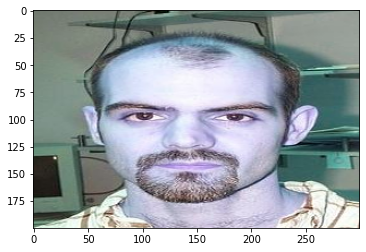

In [19]:
imshow(X[2323])

In [20]:
Y[1001]

'Motorbikes'

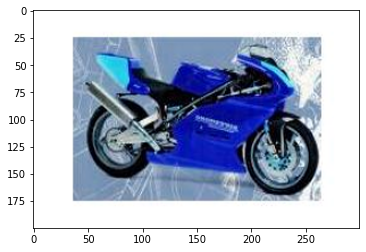

In [21]:
imshow(X[1001])

Seems all good. 

### Making one-hot encoded labels

In [22]:
label_encoder = LabelEncoder()
Y_integer_encoded = label_encoder.fit_transform(Y)
Y_integer_encoded

array([ 5,  5,  5, ..., 52, 52, 52])

In [23]:
np.save('label_encoder.npy', label_encoder.classes_)

In [24]:
len(Y_integer_encoded)

8677

In [25]:
len(Y)

8677

In [26]:
len(X)

8677

Integers have ordering property which we don't want our ML models to learn since an apple isn't in any way greater than an airplane.
So, we must create a one-hot encoding. 

In [27]:
from tensorflow.keras.utils import to_categorical
Y_one_hot = to_categorical(Y_integer_encoded)
Y_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [28]:
Y_one_hot[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [29]:
len(Y_one_hot[0])

101

To get back the label for any one-hot encoded label

In [2]:
label_encoder.inverse_transform(np.argmax(Y_one_hot[0]))

NameError: ignored

### Basic Normalization (in case of images)

In [ ]:
X_normalized = X.astype(np.float64) / 255

In [ ]:
X[0]

In [ ]:
X_normalized[0]

In [ ]:
# We wouldn't require X anymore, so, let's free up some memory
del X

### Splitting the Data

In [ ]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_normalized, Y_one_hot, test_size=0.25, random_state=42)

In [ ]:
X_train.shape

In [ ]:
Y_train.shape

Sanity Check

In [ ]:
imshow(X_train[6001])

In [ ]:
label_encoder.inverse_transform(np.argmax(Y_train[6001]))

## Saving notebook environment till here

In [ ]:
dill.dump_session('notebook_env_until_nn_models.db')

## Approach 1 - A Small CNN

**Defining Model Architecture**

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv2D(16, (3,3), activation='relu', input_shape=(200,300,3)))
model_cnn.add(Conv2D(32, (3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn.add(Conv2D(64, (3,3), activation='relu'))
model_cnn.add(Conv2D(128, (3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(101, activation='softmax'))
model_cnn.summary()

**Defining Loss and Optimizer**

In [ ]:
model_cnn.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
callbacks = [ModelCheckpoint('cnn_model.h5', monitor='val_acc', save_best_only=True),
            EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')]
model_cnn.fit(X_train, Y_train, batch_size=64, epochs=30, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)

In [ ]:
json_cnn_model = model_cnn.to_json()
with open("model_cnn.json", "w") as f:
    json.dump(json.loads(json_cnn_model), f, indent=4)

As we see above, overfitting has happened. We could try some ways of avoiding overfitting : 
    
* Dropout
* L2 regularization

## Approach 2 - CNN Model with Dropout

In [ ]:
# Architecture
model_cnn_dropout = Sequential()
model_cnn_dropout.add(Conv2D(32, (3,3), activation='relu', input_shape=(200,300,3)))
model_cnn_dropout.add(Conv2D(32, (3,3), activation='relu'))
model_cnn_dropout.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn_dropout.add(Conv2D(64, (3,3), activation='relu'))
model_cnn_dropout.add(Conv2D(64, (3,3), activation='relu'))
model_cnn_dropout.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn_dropout.add(Flatten())
model_cnn_dropout.add(Dense(512, activation='relu'))
model_cnn_dropout.add(Dropout(0.5))
model_cnn_dropout.add(Dense(101, activation='softmax'))
model_cnn_dropout.summary()

# loss and optimizer
model_cnn_dropout.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

# training
callbacks = [ModelCheckpoint('cnn_model_dropout_two.h5', monitor='val_acc', save_best_only=True),
            EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')]
model_cnn_dropout.fit(X_train, Y_train, batch_size=16, epochs=10, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)

In [ ]:
# Train some more as val accuracy seems to be improving even though it still looks like overfit
model_cnn_dropout.fit(X_train, Y_train, batch_size=16, epochs=10, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)

In [ ]:
model_cnn_dropout.save('model_cnn_dropout_with_weights.h5')

In [ ]:
json_cnn_dropout = model_cnn_dropout.to_json()

In [ ]:
with open("model_cnn_dropout.json", "w") as f:
    json.dump(json.loads(json_cnn_dropout), f, indent=4)

## Approach 3 - Transfer Learning

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)

transfer_learning_arch = base_model.output
transfer_learning_arch = GlobalAveragePooling2D()(transfer_learning_arch)
transfer_learning_arch = Dense(1024, activation='relu')(transfer_learning_arch)
transfer_learning_arch = Dropout(0.4)(transfer_learning_arch)
transfer_learning_arch = Dense(512, activation='relu')(transfer_learning_arch)
transfer_learning_arch = Dropout(0.4)(transfer_learning_arch)
predictions = Dense(101, activation='softmax')(transfer_learning_arch)

transfer_learning_model = Model(inputs=base_model.input, outputs=predictions)
transfer_learning_model.summary()

In [ ]:
#We freeze the model excepted the added layers
#279 is number of mixed 9 layer
#248 is number of mixed 8 layer

for layer in transfer_learning_model.layers[:280]:
    layer.trainable = False
for layer in transfer_learning_model.layers[280:]:
    layer.trainable = True

In [ ]:
transfer_learning_model.summary()

In [ ]:
opt=Adadelta(lr=1.0, rho=0.9, epsilon=1e-08, decay=0.0)
transfer_learning_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
callbacks = [ModelCheckpoint('transfer_learning_weights.h5', monitor='val_acc', save_best_only=True),
            EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')]
transfer_learning_model.fit(X_train, Y_train, batch_size=32, epochs=15, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)

In [ ]:
json_transfer_learning_model = transfer_learning_model.to_json()
with open("model_transfer_learning.json", "w") as f:
    json.dump(json.loads(json_transfer_learning_model), f, indent=4)

## Prediction from 2 models

#### Predicting for one image

In [ ]:
dolphin_imgs = get_images('dolphin','./data')

In [ ]:
dolphin_imgs[0]

In [ ]:
img = read_image(dolphin_imgs[0])

In [ ]:
img.shape

In [ ]:
img = img.reshape((1,200,300,3))

In [ ]:
prediction = model_cnn_dropout.predict(img)

In [ ]:
label_predicted = label_encoder.inverse_transform(np.argmax(prediction))
print(label_predicted)

In [ ]:
for var, obj in locals().items():
    print(var, sys.getsizeof(obj))

## Accuracy per category

In [ ]:
def find_accuracy_per_category(data_directory, nn_model):
    category_accuracy_dict = {}
    for category,count in return_images_per_category(data_directory):
        correctly_classified = 0
        if category == 'BACKGROUND_Google':
            continue
        Y_category = [category for _ in range(count)]
        encoded = label_encoder.transform(Y_category)
        Y_category = to_categorical(encoded, num_classes=101)
        assert Y_category.shape == (count, 101)
        X_category = np.ndarray((count, 200, 300, 3), dtype=np.float64)
        for i,img in enumerate(get_images(category, data_directory)):
            if not img.endswith('.jpg'):
                # to escape hidden ipynb checkpoints and other unnecessary files 
                continue
            X_category[i] = read_image(img) / 255
        score = nn_model.evaluate(x=X_category, y=Y_category, verbose=1)
        del X_category
        category_accuracy_dict[category] = score
    print("Accuracy found for each class")
    return category_accuracy_dict

In [ ]:
# Testing first model
cnn_dropout_score_dict = find_accuracy_per_category('./data', model_cnn_dropout)

NameError: ignored

In [ ]:
# Free memory - those variables which aren't needed
del X
del X_normalized

In [ ]:
# Testing the dropout model
cnn_dropout_score_dict = find_accuracy_per_category('./data', model_cnn_dropout)

In [ ]:
# Testing the transfer learning model
cnn_dropout_score_dict_transfer_learning = find_accuracy_per_category('./data', transfer_learning_model)

In [ ]:
average_accuracy = 0
for category, scores in cnn_dropout_score_dict.items():
    print(category,":",scores[1])
    average_accuracy += scores[1]
average_accuracy /= 101
print("Average accuracy : ",average_accuracy)

**So, as we can see, we achieve an average accuracy of 83% per category with our CNN models. This isn't bad.**

In [ ]:
def find_average_accuracy_for_model(data_directory, nn_model):
    category_accuracy_dict = find_accuracy_per_category('./data', transfer_learning_model)
    average_accuracy = 0
    for category, scores in category_accuracy_dict.items():
        print(category,":",scores[1])
        average_accuracy += scores[1]
    average_accuracy /= 101
    print("Average accuracy : ",average_accuracy)

In [ ]:
find_average_accuracy_for_model('./data',transfer_learning_model)

**Average accuracy using transfer learning model : 97%**

## What else can we do?

Due to time constraints there are a lot of things I couldn't try right now, however could be done to : 

**Improve our object classification**
- I'm certain that our CNN models could be optimized further. The dataset is quite an easy one compared to likes of imagenet, so a simple model should be able to work quite well if optimized well
- Add visualizations of losses and training and predictions
- Try other algorithms and other NN architectures

**Do Object Detection**
Currently, if you look at this dataset, most of the images are clutter free, containing image of only one object, which is also centered in most of the cases. This makes this dataset less challenging for object detection problem. Also, one could perhaps just have a bad version of sliding window or R-CNN algorithm which could do detection problem here and give good boundary boxes.

However, to improve upon that, YOLO and SSD algorithms could be used to detect where which object is in an image. 